# TMDB 10000 Movies (2022) — EDA + przygotowanie pod klasyfikację

Notebook:
- ładuje dataset (CSV),
- analizuje kolumny (typy, braki, unikalne),
- dla kolumn numerycznych podaje: **min, max, std, median** (i dodatkowo mean),
- tworzy cechy, buduje prosty model bazowy i rysuje **macierz pomyłek**.

## Założenia
- Dataset to CSV z Kaggle: anmolkohli1/the-movie-db-10000-movies-2022.
- Jeśli Twoja wersja ma inne nazwy kolumn, notebook nadal zadziała, bo analizuje kolumny dynamicznie.


In [38]:
# Jeśli uruchamiasz lokalnie: upewnij się, że masz pakiety.
# Jeśli na Colab: odkomentuj instalację.

!pip -q install pandas numpy matplotlib seaborn scikit-learn

import os
import re
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

sns.set_theme(style="whitegrid")

RANDOM_STATE = 42


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## 1) Wczytanie danych

### Opcja A (najprostsza): plik CSV pobrany ręcznie z Kaggle
1. Pobierz dataset z Kaggle.
2. Rozpakuj.
3. Wskaż `DATA_PATH` do właściwego pliku CSV.

### Opcja B: Kaggle API (lokalnie)
- Wymaga skonfigurowanego `kaggle.json` (token) w `~/.kaggle/kaggle.json`.
- W notebooku poniżej jest przykładowy blok (wyłączony domyślnie).


In [39]:
# Ustaw ścieżkę do CSV:
# Przykład: DATA_PATH = "./The Movie DB 10000 Movies 2022/tmdb_10000_movies.csv"

DATA_PATH = "./data/tmdb_10000_movies.csv"  # <- ZMIEŃ

assert os.path.exists(DATA_PATH), (
    "Nie znaleziono pliku DATA_PATH. Ustaw poprawną ścieżkę do CSV. "
    f"Podano: {DATA_PATH}"
)

df = pd.read_csv(DATA_PATH)
df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/xDMIl84Qo5Tsu62c9DGWhmPI67A.jpg,"[28, 12, 878]",505642,en,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",5470.522,/sv1xJUazXeYqALzczSZ3O6nkH75.jpg,2022-11-09,Black Panther: Wakanda Forever,False,7.5,2257
1,False,/faXT8V80JRhnArTAeYXz0Eutpv9.jpg,"[16, 12, 35, 10751, 14]",315162,en,Puss in Boots: The Last Wish,Puss in Boots discovers that his passion for a...,4289.433,/kuf6dutpsT0vSVehic3EZIqkOBt.jpg,2022-12-07,Puss in Boots: The Last Wish,False,8.6,3180
2,False,/q2fY4kMXKoGv4CQf310MCxpXlRI.jpg,"[878, 27, 35]",536554,en,M3GAN,A brilliant toy company roboticist uses artifi...,3046.049,/d9nBoowhjiiYc4FBNtQkPY7c11H.jpg,2022-12-28,M3GAN,False,7.6,1224
3,False,/s16H6tpK2utvwDtzZ8Qy4qm5Emw.jpg,"[878, 12, 28]",76600,en,Avatar: The Way of Water,Set more than a decade after the events of the...,1750.343,/t6HIqrRAclMCA60NsSmeqe9RmNV.jpg,2022-12-14,Avatar: The Way of Water,False,7.7,4964
4,False,/Aqldsq65Nj1KAkQD2MzkZsAk5N5.jpg,"[28, 53, 18]",846433,es,The Enforcer,"A noir thriller set in Miami, the film follows...",1413.509,/72V1r1G8S87ELagVxjqAUdChMCt.jpg,2022-09-22,The Enforcer,False,7.3,133


In [40]:
print("Shape:", df.shape)
df.info()

Shape: (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0       adult          10000 non-null  bool   
 1   backdrop_path      6686 non-null   object 
 2   genre_ids          10000 non-null  object 
 3   id                 10000 non-null  int64  
 4   original_language  10000 non-null  object 
 5   original_title     10000 non-null  object 
 6   overview           9057 non-null   object 
 7   popularity         10000 non-null  float64
 8   poster_path        9592 non-null   object 
 9   release_date       10000 non-null  object 
 10  title              10000 non-null  object 
 11  video              10000 non-null  bool   
 12  vote_average       10000 non-null  float64
 13  vote_count         10000 non-null  int64  
dtypes: bool(2), float64(2), int64(2), object(8)
memory usage: 957.2+ KB


## 2) Szybka kontrola jakości
- duplikaty
- braki danych
- typy kolumn


In [41]:
n_duplicates = df.duplicated().sum()
print("Liczba duplikatów wierszy:", n_duplicates)

missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20).to_frame("missing_rate"))

Liczba duplikatów wierszy: 0


,missing_rate
backdrop_path,0.3314
overview,0.0943
poster_path,0.0408
adult,0.0000
genre_ids,0.0000
id,0.0000
original_language,0.0000
original_title,0.0000
popularity,0.0000
release_date,0.0000


## 3) Automatyczna analiza każdej kolumny

Dla każdej kolumny raportujemy:
- dtype
- liczba braków i % braków
- liczba unikalnych wartości
- jeśli numeryczna: min/max/std/median (+ mean)

Uwaga: jeśli jakieś kolumny są liczbami zapisanymi jako tekst (np. z przecinkami), spróbujemy je bezpiecznie skonwertować.


In [42]:
def try_parse_numeric(series: pd.Series) -> pd.Series:
    """Próba konwersji string->numeric (usuwa $, przecinki, spacje)."""
    if series.dtype != "object":
        return series

    s = series.astype(str)
    s = s.replace({"None": np.nan, "nan": np.nan, "NaN": np.nan})
    s = s.str.replace(r"[\$,]", "", regex=True).str.strip()

    numeric = pd.to_numeric(s, errors="coerce")
    # jeśli konwersja ma sens (wystarczająco dużo wartości przeszło), zwróć numeric
    non_na_original = series.notna().sum()
    non_na_numeric = numeric.notna().sum()
    if non_na_original == 0:
        return series
    if non_na_numeric / non_na_original >= 0.85:
        return numeric
    return series


df2 = df.copy()
for c in df2.columns:
    df2[c] = try_parse_numeric(df2[c])

def column_report(frame: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for col in frame.columns:
        s = frame[col]
        n = len(s)
        n_missing = int(s.isna().sum())
        missing_rate = n_missing / n if n else np.nan
        nunique = int(s.nunique(dropna=True))
        dtype = str(s.dtype)

        stats = {
            "min": np.nan,
            "max": np.nan,
            "std": np.nan,
            "median": np.nan,
            "mean": np.nan,
        }
        if pd.api.types.is_numeric_dtype(s):
            stats["min"] = float(np.nanmin(s.values)) if s.notna().any() else np.nan
            stats["max"] = float(np.nanmax(s.values)) if s.notna().any() else np.nan
            stats["std"] = float(np.nanstd(s.values, ddof=1)) if s.notna().sum() > 1 else np.nan
            stats["median"] = float(np.nanmedian(s.values)) if s.notna().any() else np.nan
            stats["mean"] = float(np.nanmean(s.values)) if s.notna().any() else np.nan

        rows.append(
            {
                "column": col,
                "dtype": dtype,
                "missing_count": n_missing,
                "missing_rate": missing_rate,
                "nunique": nunique,
                **stats,
            }
        )
    return (
        pd.DataFrame(rows)
        .sort_values(["missing_rate", "nunique"], ascending=[False, False])
        .reset_index(drop=True)
    )


report = column_report(df2)
display(report)

# Zapis raportu do CSV obok danych
out_report_path = os.path.join(os.path.dirname(DATA_PATH), "column_report.csv")
report.to_csv(out_report_path, index=False)
print("Zapisano raport:", out_report_path)

,column,dtype,missing_count,missing_rate,nunique,min,max,std,median,mean
0,backdrop_path,object,3314,0.3314,6681,NaN,NaN,NaN,NaN,NaN
1,overview,object,943,0.0943,9047,NaN,NaN,NaN,NaN,NaN
2,poster_path,object,408,0.0408,9586,NaN,NaN,NaN,NaN,NaN
3,id,int64,0,0.0000,10000,38492.0,1081865.000,117744.610450,969581.0000,941326.445200
4,original_title,object,0,0.0000,9932,NaN,NaN,NaN,NaN,NaN
5,title,object,0,0.0000,9865,NaN,NaN,NaN,NaN,NaN
6,popularity,float64,0,0.0000,4352,0.6,5470.522,95.653698,1.4265,11.748981
7,genre_ids,object,0,0.0000,1193,NaN,NaN,NaN,NaN,NaN
8,vote_count,int64,0,0.0000,399,0.0,7387.000,240.481990,1.0000,31.449400
9,release_date,object,0,0.0000,365,NaN,NaN,NaN,NaN,NaN


Zapisano raport: ./data/column_report.csv


## 4) Wizualizacje: rozkłady, korelacje

### 4.1 Rozkłady wybranych kolumn numerycznych
Automatycznie wybieramy kilka numerycznych kolumn o największej wariancji.


Liczba kolumn numerycznych: 6


,variance
id,1.386379e+10
vote_count,5.783159e+04
popularity,9.149630e+03
vote_average,1.149031e+01
adult,0.000000e+00
video,0.000000e+00


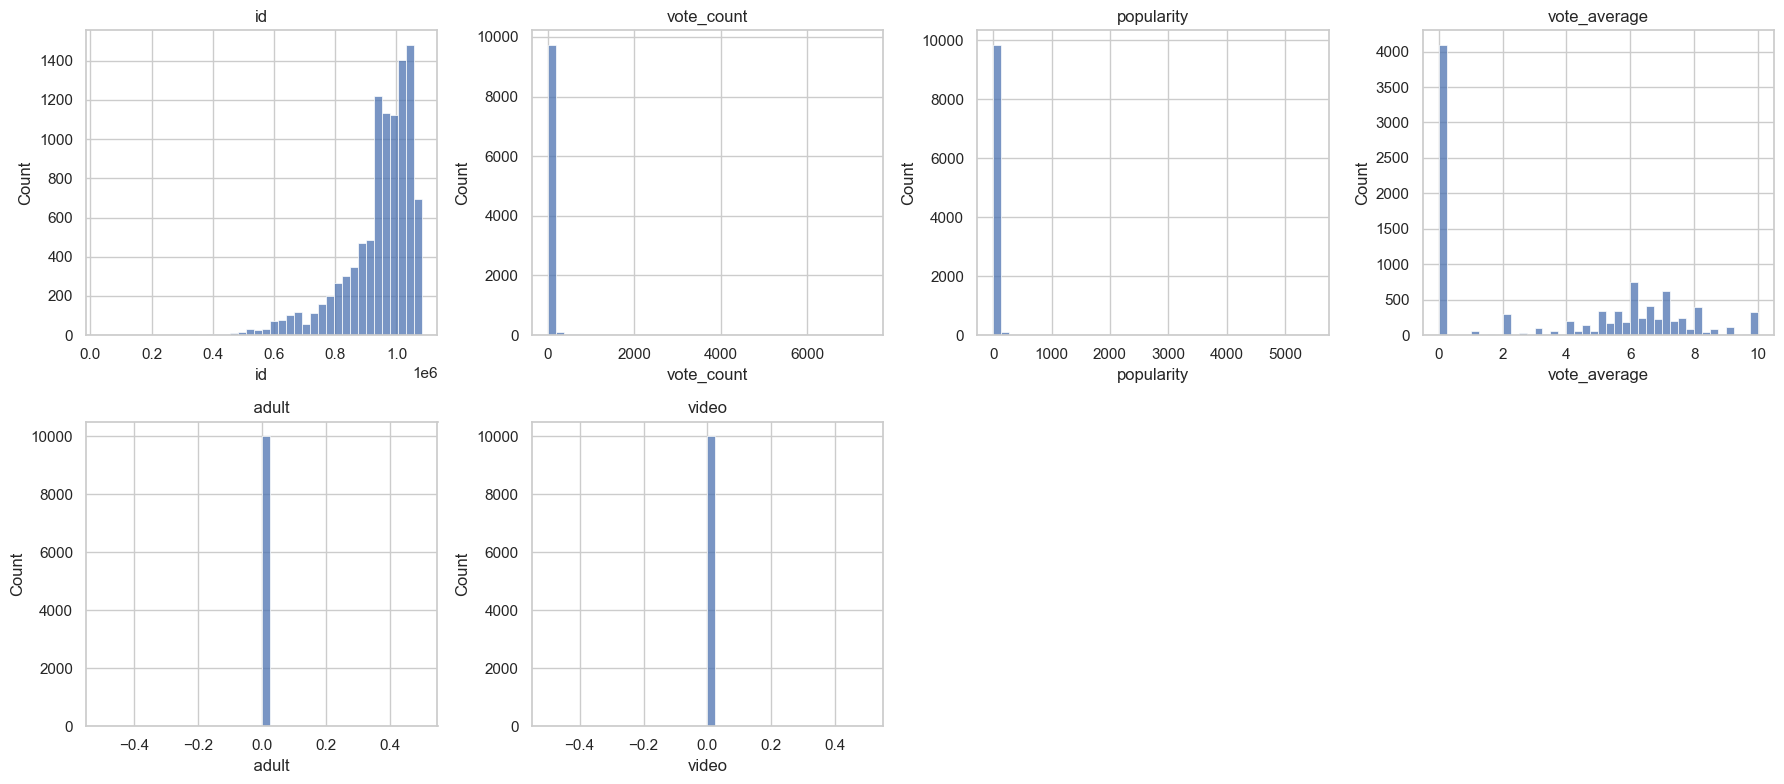

In [43]:
num_cols = [c for c in df2.columns if pd.api.types.is_numeric_dtype(df2[c])]
print("Liczba kolumn numerycznych:", len(num_cols))

if len(num_cols) > 0:
    variances = df2[num_cols].var(numeric_only=True).sort_values(ascending=False)
    top = variances.head(8).index.tolist()
    display(variances.head(15).to_frame("variance"))

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
    axes = axes.flatten()
    for ax, col in zip(axes, top):
        sns.histplot(df2[col], kde=False, ax=ax, bins=40)
        ax.set_title(col)
    for ax in axes[len(top) :]:
        ax.axis("off")
    plt.tight_layout()
else:
    print("Brak kolumn numerycznych do pokazania.")

### 4.2 Mapa korelacji (numeryczne)
Uwaga: korelacje mają sens tylko dla sensownie numerycznych danych.


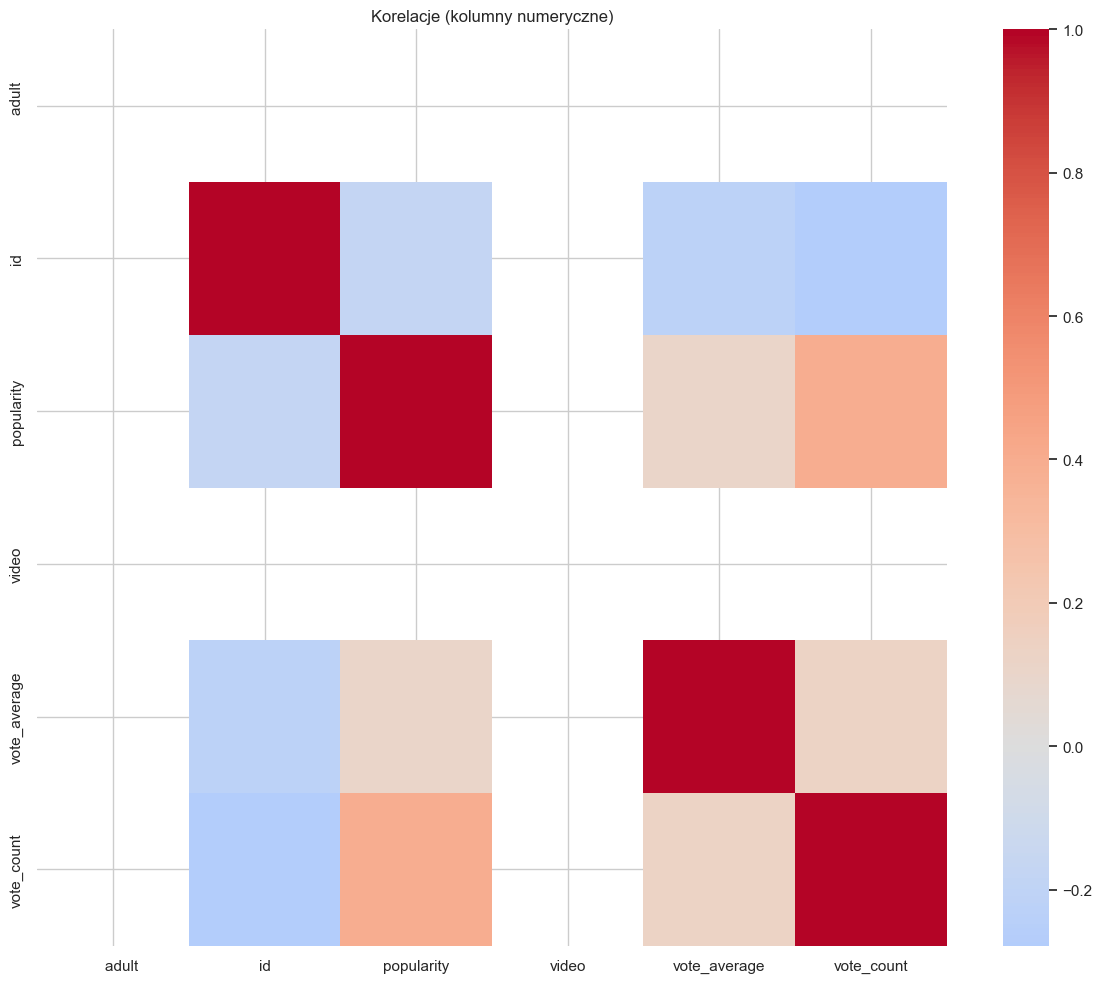

In [44]:
if len(num_cols) >= 2:
    corr = df2[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Korelacje (kolumny numeryczne)")
    plt.tight_layout()
    plt.show()
else:
    print("Za mało kolumn numerycznych do korelacji.")

## 5) Przygotowanie pod klasyfikację

W tym datasetcie zwykle nie ma gotowej etykiety klasy (target). Trzeba ją zdefiniować.

Poniżej tworzę przykładowy target binarny `target_hit`:
- jeśli istnieje kolumna `revenue`: film jest "hitem" gdy `revenue` >= 75 percentyla.
- jeśli `revenue` nie ma, ale jest `vote_average`: "hit" gdy `vote_average` >= 75 percentyla.
- jeśli żadnej nie ma, notebook poprosi o ręczny wybór.

Ważne: to tylko baseline — docelowo wybierz target zgodny z Twoim zadaniem.


In [45]:
def pick_target_column(frame: pd.DataFrame) -> str:
    candidates = ["revenue", "vote_average", "popularity", "vote_count"]
    for c in candidates:
        if c in frame.columns and pd.api.types.is_numeric_dtype(frame[c]):
            if frame[c].notna().sum() > 50:
                return c
    return ""


target_source = pick_target_column(df2)
print("Wybrana kolumna bazowa do targetu:", target_source or "BRAK")

if not target_source:
    raise ValueError(
        "Nie znaleziono sensownej kolumny do zbudowania targetu. "
        "Podaj ręcznie nazwę kolumny numerycznej (np. revenue/vote_average)."
    )

q = df2[target_source].quantile(0.75)
df2["target_hit"] = (df2[target_source] >= q).astype(int)
print(f"Próg (75 percentyl) dla {target_source}: {q}")
df2["target_hit"].value_counts(normalize=True).rename("share")

Wybrana kolumna bazowa do targetu: vote_average
Próg (75 percentyl) dla vote_average: 6.7


target_hit
0    0.7479
1    0.2521
Name: share, dtype: float64

## 6) Feature engineering (lekki, bezpieczny)

- Usuwamy kolumny, które są oczywistym przeciekiem targetu (np. jeśli target z `revenue`, to `revenue` usuwamy z cech).
- Wykrywamy kolumny tekstowe z bardzo wysoką krotnością (np. `overview`) i domyślnie je pomijamy (baseline).

Jeżeli chcesz model z NLP na `overview`/`tagline`, to zrobimy osobny pipeline (TF-IDF). Tu skupiamy się na klasycznym baseline.


In [46]:
target_col = "target_hit"

# Potencjalne kolumny ID / przecieki / zbyt opisowe
drop_cols = {target_col}
drop_cols.add(target_source)  # usuń źródło targetu by uniknąć leakage

# Typowe kolumny identyfikatorów (jeśli istnieją)
for c in ["id", "imdb_id", "tmdb_id", "title", "original_title"]:
    if c in df2.columns:
        # title czasem daje sygnał, ale zwykle słabo uogólnia; do baseline drop
        drop_cols.add(c)

# Heurystyka: bardzo długi tekst -> drop w baseline
text_like = []
for c in df2.columns:
    if df2[c].dtype == "object":
        avg_len = df2[c].dropna().astype(str).str.len().mean() if df2[c].notna().any() else 0
        if avg_len and avg_len > 80:
            text_like.append(c)
drop_cols.update(text_like)

print("Kolumny odrzucone (baseline):")
print(sorted(drop_cols))

X = df2.drop(columns=[c for c in drop_cols if c in df2.columns])
y = df2[target_col].astype(int)

print("X shape:", X.shape)
print("y distribution:")
display(y.value_counts().to_frame("count"))

num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if X[c].dtype == "object"]

print("Num features:", len(num_features))
print("Cat features:", len(cat_features))
display(pd.DataFrame({"num": num_features}).head(20))
display(pd.DataFrame({"cat": cat_features}).head(20))

Kolumny odrzucone (baseline):
['id', 'original_title', 'overview', 'target_hit', 'title', 'vote_average']
X shape: (10000, 9)
y distribution:


,count
target_hit,
0,7479
1,2521


Num features: 4
Cat features: 5


,num
0,adult
1,popularity
2,video
3,vote_count


,cat
0,backdrop_path
1,genre_ids
2,original_language
3,poster_path
4,release_date


## 7) Model bazowy + macierz pomyłek

- Pipeline:
  - num: imputacja medianą
  - cat: imputacja "missing" + OneHotEncoder
  - model: LogisticRegression

Wynik: raport klasyfikacji + macierz pomyłek.


              precision    recall  f1-score   support

           0     0.7586    0.9746    0.8531      1496
           1     0.5128    0.0794    0.1375       504

    accuracy                         0.7490      2000
   macro avg     0.6357    0.5270    0.4953      2000
weighted avg     0.6967    0.7490    0.6728      2000



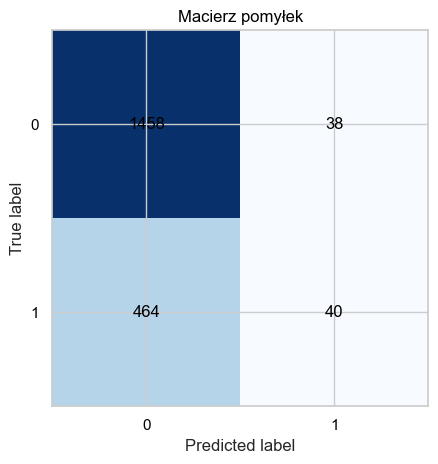

ROC-AUC: 0.6808


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", min_frequency=10),
        ),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

clf = LogisticRegression(max_iter=10147, n_jobs=None)

model = Pipeline(steps=[("preprocess", preprocess), ("clf", clf)])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(values_format="d", cmap="Blues", colorbar=False)

# wymuś czarny kolor wszystkich napisów w komórkach
for t in disp.text_.ravel():
    t.set_color("black")
    t.set_fontsize(12)  # opcjonalnie

plt.title("Macierz pomyłek", color="black")
plt.xticks(color="black")
plt.yticks(color="black")
plt.tight_layout()
plt.show()

# ROC-AUC (jeśli możliwe)
if hasattr(model.named_steps["clf"], "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC:", round(auc, 4))